In [1]:
%pylab inline
import h5py
# import fitsio
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import hist
from astropy import coordinates as coords
from scipy import stats
import networkx as nx

import gwb

Populating the interactive namespace from numpy and matplotlib


In [2]:
print(style.available)

['seaborn-dark', 'seaborn-pastel', 'fivethirtyeight', 'seaborn-whitegrid', 'grayscale', 'seaborn-white', 'seaborn-paper', 'seaborn-talk', 'classic', 'seaborn-darkgrid', 'seaborn-muted', 'dark_background', 'seaborn-deep', 'seaborn-ticks', 'seaborn-dark-palette', 'ggplot', 'seaborn-colorblind', 'seaborn-poster', 'seaborn-bright', 'seaborn-notebook', 'bmh']


In [3]:
style.use(['seaborn-colorblind', 'notebook.mplstyle'])

# Load Data

In [4]:
tgas = gwb.TGASData('../data/stacked_tgas.fits')

In [5]:
pairidx_rand = fits.getdata('../output/random/snr8_random200000.fits')
with h5py.File("../output/random/snr8_random200000_vscatter0-lratio.h5") as f:
    lnH1_rand = f['lnH1'].value
    lnH2_rand = f['lnH2'].value
    llr_rand = lnH1_rand - lnH2_rand
# throw out nans
bad = isnan(llr_rand)
pairidx_rand = pairidx_rand[~bad]
lnH1_rand = lnH1_rand[~bad]
lnH2_rand = lnH2_rand[~bad]
llr_rand = llr_rand[~bad]

# pairidx_rand_sn32 = fits.getdata('../output/random/snr32_random100000.fits')
# with h5py.File("../output/random/snr32_random100000_vscatter0-lratio.h5") as f:
#     lnH1_rand_sn32 = f['lnH1'].value
#     lnH2_rand_sn32 = f['lnH2'].value
#     llr_rand_sn32 = lnH1_rand_sn32 - lnH2_rand_sn32
# # throw out nans
# bad = isnan(llr_rand_sn32)
# pairidx_rand_sn32 = pairidx_rand_sn32[~bad]
# lnH1_rand_sn32 = lnH1_rand_sn32[~bad]
# lnH2_rand_sn32 = lnH2_rand_sn32[~bad]
# llr_rand_sn32 = llr_rand_sn32[~bad]

# pairidx = fits.getdata('../output/21081/snr8_n128_dv10_new.fits')
# with h5py.File("../output/21081/snr8_n128_dv10_vscatter0-lratio.h5") as f:
#     lnH1 = f['lnH1'].value
#     lnH2 = f['lnH2'].value
#     llr = lnH1 - lnH2
pairidx = fits.getdata('../output/23560/snr8_r10_dv10.fits')
with h5py.File("../output/23560/snr8_r10_dv10_vscatter0-lratio.h5") as f:
# pairidx = fits.getdata('../output/26187//snr8_r10_dv10.fits')
# with h5py.File("../output/26187/snr8_r10_dv10_vscatter0-lratio.h5") as f:
    lnH1 = f['lnH1'].value
    lnH2 = f['lnH2'].value
    llr = lnH1 - lnH2

In [6]:
parallax_snr = tgas.parallax_snr
vtan = tgas.get_vtan().value
c = tgas.get_coord()
d = tgas.get_distance().value

star1, star2 = pairidx['star1'], pairidx['star2']
min_snr = np.min(np.vstack((parallax_snr[star1], parallax_snr[star2])), axis=0)
dvtan = norm(vtan[star1]-vtan[star2], axis=1)
vtanmean = (vtan[star1] + vtan[star2])*0.5
sep = c[star1].separation_3d(c[star2]).value
sep_sky = c[star1].separation(c[star2])

c1 = c[star1]
c2 = c[star2]
ra1, dec1 = c1.ra.value, c1.dec.value
ra2, dec2 = c2.ra.value, c2.dec.value
l1, b1 = c1.transform_to(coords.Galactic).l.value, c1.transform_to(coords.Galactic).b.value
l2, b2 = c2.transform_to(coords.Galactic).l.value, c2.transform_to(coords.Galactic).b.value
d1 = d[star1]
d2 = d[star2]
dmean = (d1+d2)*0.5

/Users/semyeong/projects/gaia-wide-binaries/gwb/data.py:102: RuntimeWarning: invalid value encountered in sqrt
  tmp = self._data['parallax'] * (0.5 + 0.5*np.sqrt(1 - 16/snr**2))


In [7]:
pairidx.size

271232

# Figure: Likelihood ratio histogram

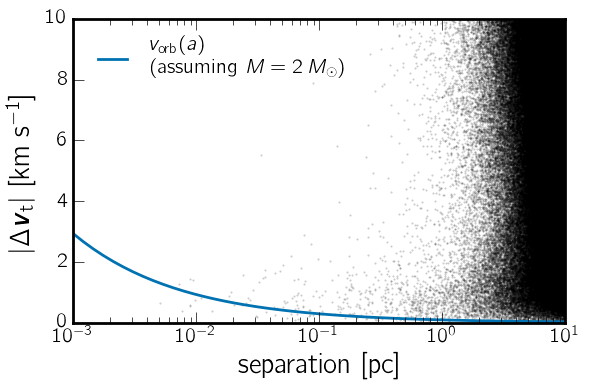

In [24]:
# import corner

# corner.hist2d(log10(pairidx['sep']), pairidx['delta_v'],
#               data_kwargs={"alpha":.3})
# axes([0.2,0.18,0.75,0.77])
plot(pairidx['sep'], pairidx['delta_v'], 'k.', alpha=0.2, ms=3, rasterized=True)
xlabel(r'separation [pc]')
yl = ylabel(r'$|\Delta \boldsymbol{v}_{\rm{t}}|$ [km s$^{-1}$]')
# figtext(0.05, 0.55, "tangential velocity difference", ha='center', va='center',
#         rotation='vertical', size=20)

from astropy.constants import G
tmpsep = logspace(-3,1)
v = sqrt(G*(2*u.solMass)/(tmpsep*u.pc)).to(u.km/u.s).value
plot(tmpsep, v, label=r"$v_\mathrm{orb} (a)$"
     "\n"
     r"(assuming $M=2\,M_\odot$)", lw=2)
legend(loc='upper left', fontsize=15, frameon=False)

xscale('log')
_ = yticks([0,2,4,6,8,10])
tight_layout()
savefig('../paper/figures/sep_dvtan.pdf', dpi=150)

In [ ]:
fig, ax = subplots(1, 2, figsize=(10,4))
fig.subplots_adjust(left=0.1, right=0.98, bottom=0.2, top=0.95, wspace=.2)
sca(ax[0])
hist(llr, bins=np.linspace(-50,12,256), color='k', histtype='step',
        normed=True, label='entire candidate pairs', lw=2)
# slices in dvtan
for cut, color in zip([0.5, 5, 9.5], ['#253494','#2c7fb8','#41b6c4']):
    cond_dvtan_strip = fabs(dvtan-cut)<0.5
    print('dvtan', cut, cond_dvtan_strip.sum())
    hist(llr[cond_dvtan_strip], lw=1.5,
         bins=np.linspace(-15,12,64), color=color,
         normed=True, histtype='step',
         label=r'|$\Delta v_t -$%.1f| < 0.5' % (cut), )
# random pairs of stars
_ = hist(llr_rand, bins=linspace(-15,12,64),
         color='0.8', normed=True, zorder=-1,
         label='random pairs')

legend(loc='upper left', frameon=False)
xlim(-5,10)
xlabel(r'$\ln (L_1/L_2)$')
ylabel('density')
tick_params(axis='both', length=8, width=1.)

sca(ax[1])
# slices in ln(L1/L2)
# for cut, color, ms in zip([2, 5, 6.5], ['#969696', '#636363', '#252525'], [4, 2, .5]):
for cut, color, ms in zip([2, 5, 6.5], ['0.7', '0.4', '0.'], [4, 2, .5]):
    cond_lr_slice = fabs(llr-cut)<0.25
    print('ln(L1/L2)', cut, cond_lr_slice.sum())
    plot(log10(pairidx['sep'][cond_lr_slice]), pairidx['delta_v'][cond_lr_slice],
         c=color, marker='o', ls='None', ms=2, alpha=.5,
         label='|$\ln (L_1/L_2)-$%.1f|<0.25' % (cut))
xlabel('log separation [pc]',)
ylabel('$|\Delta v_t|$ [km s$^{-1}$]', labelpad=-5)
xticks([-2,-1,0,1])
leg = legend(loc='upper left', numpoints=1, markerscale=3, frameon=False)

# savefig('../paper/figures/likelihoodratios.pdf')

# Figure: likelihood ratio / sep-dvtan (NEW)

In [12]:
v_cuts = [(0, 2.5), (2.5, 5), (5, 7.5), (7.5, 10)]
v_colors = ['#7a0177', '#c51b8a', '#f768a1', '#fbb4b9']

llr_cuts = [(-6, -2), (-2, 2), (2, 6), (6, 10)]
llr_colors = ['#bae4bc', '#7bccc4', '#43a2ca', '#0868ac']

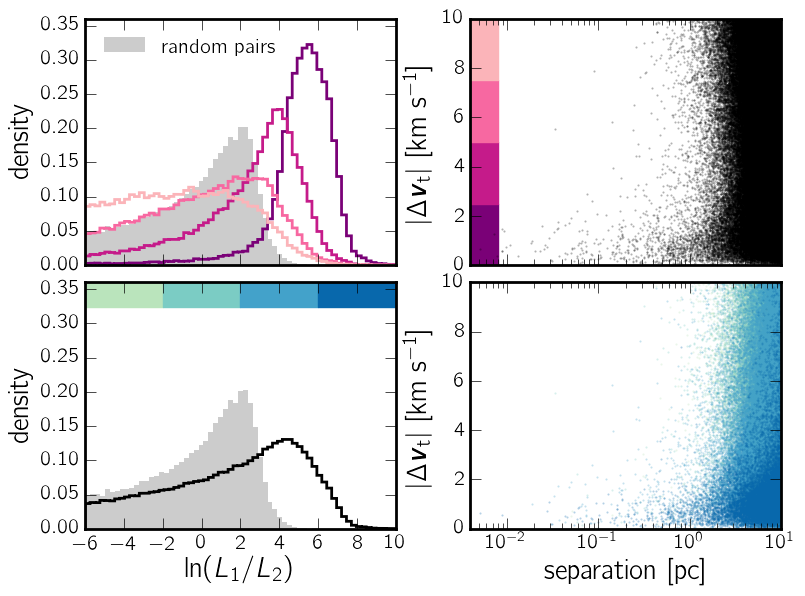

In [72]:
fig ,ax = plt.subplots(2,2,figsize=(8,6), sharex='col')
fig.subplots_adjust(left=0.1,bottom=0.12,top=0.97,right=0.97, hspace=0.07, wspace=0.24)
ax[1,0].hist(llr,
             bins=np.linspace(-6, 10, 64),
             histtype='step', normed=True, linewidth=2,
             color='k')

_ = ax[1,0].hist(llr_rand, bins=linspace(-6,10,64),
         color='0.8', normed=True, zorder=-1,
         label='random pairs')

ax[1,0].set_xlim(-6,10)
ax[1,0].set_ylim(0, 0.36)
ax[1,0].set_xlabel(r"$\ln(L_1/L_2)$")
ax[1,0].set_ylabel("density")

ax[1,1].set_xlim(4E-3, 1E1)
ax[1,1].set_ylim(0, 10)
ax[1,1].set_xlabel(r'separation [pc]')
ax[1,1].set_xscale('log')
ax[1,1].set_ylabel(r'$|\Delta \boldsymbol{v}_{\rm{t}}|$ [km s$^{-1}$]')

for i,(l,r) in enumerate(llr_cuts):
    ax[1,0].fill_betweenx([ax[1,0].get_ylim()[1]*0.9,1.], l, r,
                          color=llr_colors[i], zorder=-100)
    idx = ((llr) > l) & (llr < r)
    ax[1,1].plot(pairidx['sep'][idx], pairidx['delta_v'][idx],
                 color=llr_colors[i], 
                 linestyle='none', marker='.', alpha=0.3, ms=3,
                 markeredgecolor='none', markeredgewidth=0, rasterized=True)

_ = ax[0,0].hist(llr_rand, bins=linspace(-6,10,64),
         color='0.8', normed=True, zorder=-1,
         label='random pairs')
ax[0,1].plot(pairidx['sep'], pairidx['delta_v'],
             color='k', linestyle='none', marker='.', zorder=-10, alpha=0.3, ms=3, rasterized=True)

ax[0,0].set_xlim(-6,10)
ax[0,0].set_ylim(0, 0.36)
ax[0,0].set_ylabel("density")
ax[0,0].legend(loc='upper left', frameon=False, fontsize=15)

ax[0,1].set_xlim(4E-3, 1E1)
ax[0,1].set_ylim(0, 10)
ax[0,1].set_xscale('log')
ax[0,1].set_ylabel(r'$|\Delta \boldsymbol{v}_{\rm{t}}|$ [km s$^{-1}$]')

for i,(l,r) in enumerate(v_cuts):
    xlims = ax[0,1].get_xlim()
    xp10 = xlims[0]*2
    ax[0,1].fill_between([0,xp10], l, r, color=v_colors[i], zorder=-100)

    idx = (pairidx['delta_v'] > l) & (pairidx['delta_v'] < r)
    ax[0,0].hist(llr[idx], bins=np.linspace(-6, 10, 64), 
                 histtype='step', normed=True, color=v_colors[i], linewidth=2);
        
# savefig('../paper/figures/likelihoodratios.pdf')

In [ ]:
_ = hist(llr, bins=linspace(2,13,128),cumulative=-1, log=True, histtype='step')
_ = hist(llr[sep<1], bins=linspace(2,13,128),cumulative=-1, log=True)
_ = hist(llr[sep>1], bins=linspace(2,13,128),cumulative=-1, log=True, histtype='step')
gca().invert_xaxis()
ylabel('cumulative number of pairs', size=15)
xlabel('$\ln (L_1/L_2)$')

figure()
_=hist(llr[sep<1], linspace(-50,50,128))
xlim(-5,15)
grid()

In [75]:
sum(cond_lr_cut != (llr>6))

2244

In [76]:
sum(cond_lr_cut & ~(llr>6)),sum(~cond_lr_cut & (llr>6))

(1009, 1235)

In [7]:
cond_lr_cut = llr>6
print(cond_lr_cut.sum(), sum((sep<1)&cond_lr_cut))
cmpairs = pairidx[cond_lr_cut]

13058 377


In [ ]:
sum(llr_rand>6)/llr_rand.size, sum((llr_rand>6) & (pairidx_rand['delta_v']<10))/(pairidx_rand['delta_v']<10).sum()

# Examine the network of pairs

In [33]:
cmpairs

FITS_rec([(53377, 125205, 0.90733566482888817, 4.9494188447380116),
       (53322, 125404, 0.89618367860493753, 8.2850909966274919),
       (8392, 8849, 1.2381335879134532, 7.7528281772281362), ...,
       (8392, 8789, 0.56086097221274134, 6.8178987956535355),
       (1448463, 1857854, 1.9483583411382581, 9.7641665336806334),
       (243473, 249041, 3.8304396084119166, 8.2431487839354887)], 
      dtype=(numpy.record, [('star1', '>i8'), ('star2', '>i8'), ('delta_v', '>f8'), ('sep', '>f8')]))

In [10]:
graph = nx.Graph()
graph.add_edges_from(
    [(i,j, {'lnL1/L2':ll}) for (i,j,dvtan,s), ll in zip(cmpairs, llr[llr>6])])

In [11]:
connected = array([array(list(c)) for c in nx.connected_components(graph)])
sizes = array([len(c) for c in nx.connected_components(graph)])
print('number of nodes %i' % (len(graph)))
print('total number of connected components %i' % (connected.size))
print(min(sizes),max(sizes))

number of nodes 10606
total number of connected components 4555
2 151


In [11]:
nn_nodes = array([len(graph.neighbors(i)) for i in graph.nodes()])
print('most connected star ind %i connection size %i' % (graph.nodes()[nn_nodes.argmax()], nn_nodes.max()))
print(tgas[graph.nodes()[nn_nodes.argmax()]]._data)

most connected star ind 8447 connection size 94
(999999, b'1799-272-1', 1635378410781933568, 65194648616227840, 1590144, 2015.0, 56.26374575011429, 0.36181951349967956, 23.83922208386048, 0.21546087064235175, 7.468173593228016, 0.2931616314275865, 20.186181710799726, 1.1461772654699256, -45.604178339753034, 0.6290401450966729, -0.4609932005405426, 0.27362871170043945, -0.6606985330581665, 0.49364084005355835, -0.4206797480583191, 0.512130618095398, -0.6094832420349121, -0.31514298915863037, 0.26474204659461975, -0.5790168642997742, 115, 115, 115, 109, 0, 6, nan, 0.7439913038773959, 499.22779128128053, 84, 7.279817581176758, 1.758386254310608, 3.12755219056271e-05, 5, 16, 70, 0.17876558005809784, 0.49477386474609375, 0.18814802169799805, 0.5053095817565918, -75.85814666748047, 5.710628986358643, -32.41566467285156, 25.39784812927246, 140, 372323.00262151373, 740.066273779666, 11.597470392962894, b'NOT_AVAILABLE', 166.41429392479583, -24.025049331913806, 59.391084445239, 3.91346651732152

In [ ]:
tmass = fits.getdata('../data/tgas_tmassj.fits', ext=1)
jhk = Table.read('result.vot', format='votable')

In [78]:
mwsc = Table.read('../data/J_A+A_585_A101/catalog.dat', readme='../data/J_A+A_585_A101/ReadMe',
                 format='ascii.cds')
print('total number of mwsc', len(mwsc))
print('number of mwsc d<600 pc', (mwsc['d']<600).sum())

total number of mwsc 3210
number of mwsc d<600 pc 135


In [56]:
components = sorted(nx.connected_component_subgraphs(graph), key=len, reverse=True)

comp_dict = {idx: comp.nodes() for idx, comp in enumerate(components)}
attr = {n: comp_id for comp_id, nodes in comp_dict.items() for n in nodes}

nx.set_node_attributes(graph, "group_id", attr)
print(graph.nodes(data=True)[:3])

[(1310720, {'group_id': 319, 'component': 319}), (16385, {'group_id': 320, 'component': 320}), (32772, {'group_id': 321, 'component': 321})]


In [74]:
star_tgas_row = array(graph.nodes())
star_tgas_source_id = tgas.source_id[star_tgas_row]
star_tgas_ra = tgas.ra.value[star_tgas_row]
star_tgas_dec = tgas.dec.value[star_tgas_row]
star_tgas_parallax = tgas.parallax.value[star_tgas_row]
star_tgas_gmag = tgas._data['phot_g_mean_mag'][star_tgas_row]

star_tgas_dist = tgas.get_distance().to(u.pc).value[star_tgas_row]

star_tmass_designation = tmass['designation'][star_tgas_row]
star_tmass_jmag = tmass['j_m'][star_tgas_row]

# star_rave_RAVE_OBS_ID = 

star_group_id = array([graph.node.get(n)['group_id'] for n in star_tgas_row])



/Users/semyeong/projects/gaia-wide-binaries/gwb/data.py:102: RuntimeWarning: invalid value encountered in sqrt
  tmp = self._data['parallax'] * (0.5 + 0.5*np.sqrt(1 - 16/snr**2))


In [50]:
pair_tgas_row = array(graph.edges())
pair_star_row = array([list(map(lambda node: where(star_tgas_row == node)[0][0], [star1, star2])) for star1, star2 in pair_tgas_row])

pair_star_row1 = pair_star_row[:,0]
pair_star_row2 = pair_star_row[:,1]
assert (pair_star_row1<pair_star_row2).all()
stars_c = tgas.get_coord()[star_tgas_row]
pair_angular_separation = stars_c[pair_star_row1].separation(stars_c[pair_star_row2]).to(u.arcmin).value
pair_separation = stars_c[pair_star_row1].separation_3d(stars_c[pair_star_row2]).to(u.pc).value
pair_lnL1L2 = array([graph.get_edge_data(i,j)['lnL1/L2'] for i,j in pair_tgas_row])

/Users/semyeong/projects/gaia-wide-binaries/gwb/data.py:102: RuntimeWarning: invalid value encountered in sqrt
  tmp = self._data['parallax'] * (0.5 + 0.5*np.sqrt(1 - 16/snr**2))


In [75]:
group_id = array([i for i in comp_dict.keys()])
group_size = array([len(comp_dict[i]) for i in group_id])
group_mean_ra = array([ mean(star_tgas_ra[star_group_id==i]) for i in group_id])
group_mean_dec = array([ mean(star_tgas_dec[star_group_id==i]) for i in group_id])
group_mean_dist = array([ mean(star_tgas_dist[star_group_id==i]) for i in group_id])

In [100]:
group_c = coords.SkyCoord(group_mean_ra*u.deg, group_mean_dec*u.deg, group_mean_dist*u.pc)
mwsc_c = coords.SkyCoord(mwsc['GLON'], mwsc['GLAT'], distance=mwsc['d'].to(u.pc), frame=coords.Galactic,) 

group_mwsc_match = group_c.match_to_catalog_3d(mwsc_c,)

(0, 20)

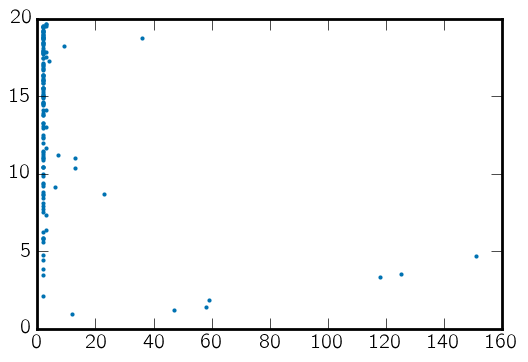

In [106]:
plot(group_size, group_mwsc_match[2],'.')
ylim(0,20)

(-300, 300)

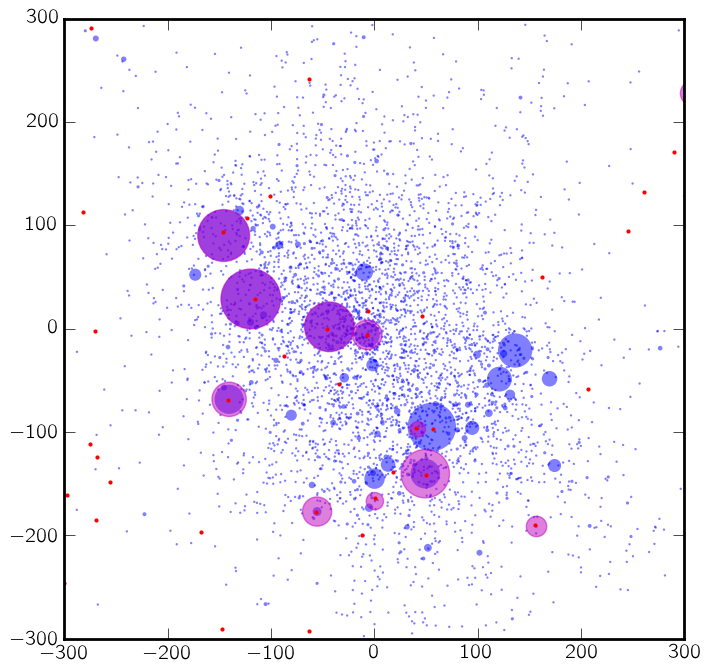

In [120]:
figure(figsize=(8,8))
cgx, cgy, cgz = group_c.transform_to(coords.Galactic).cartesian.xyz
scatter(cgx, cgy,
        s=group_size**1.5, alpha=.5)
scatter(cgx[group_mwsc_match[2]<5*u.pc], cgy[group_mwsc_match[2]<5*u.pc],
        s=group_size**1.5, alpha=.5, color='m')
plot(mwsc_c.cartesian.x[mwsc['d']<500*u.pc], mwsc_c.cartesian.y[mwsc['d']<500*u.pc], 'r.')
xlim(-300,300)
ylim(-300,300)

In [121]:
star_c = coords.SkyCoord(star_tgas_ra*u.deg, star_tgas_dec*u.deg, star_tgas_dist*u.pc,)
star_mwsc_match = star_c.match_to_catalog_3d(mwsc_c)

(array([  3.,   0.,   3.,   7.,  23.,  11.,  19.,  20.,  20.,  27.,  16.,
         25.,  36.,  24.,  29.,  19.,  29.,  29.,  20.,  21.,  24.,  21.,
         21.,  17.,  18.,  21.,  13.,  27.,  20.,  12.,  19.,  18.,  15.,
         17.,  23.,  18.,  19.,  21.,  18.,  12.,  19.,  14.,  19.,  19.,
         13.,  26.,  14.,  25.,  19.,  22.]),
 array([  0. ,   0.4,   0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,
          3.6,   4. ,   4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,
          7.2,   7.6,   8. ,   8.4,   8.8,   9.2,   9.6,  10. ,  10.4,
         10.8,  11.2,  11.6,  12. ,  12.4,  12.8,  13.2,  13.6,  14. ,
         14.4,  14.8,  15.2,  15.6,  16. ,  16.4,  16.8,  17.2,  17.6,
         18. ,  18.4,  18.8,  19.2,  19.6,  20. ]),
 <a list of 50 Patch objects>)

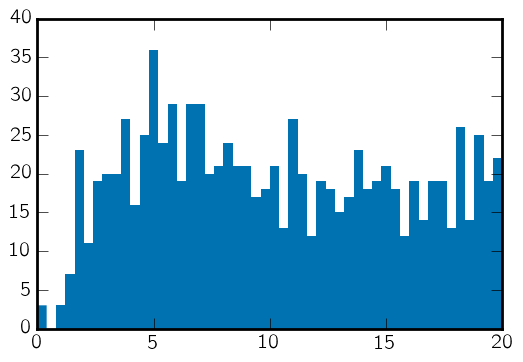

In [123]:
hist(star_mwsc_match[2], linspace(0,20,51))

In [125]:
mwsc_match_dict = {i: star_mwsc_match[0][star_group_id==i] for i in group_id}

In [129]:
mwsc_match_dict[3]

array([1459, 1578, 1578, 1578, 1578, 1459, 1578, 1578, 1578, 1578, 1578,
       1578, 1578, 1578, 1578, 1578, 1578, 1578, 1578, 1578, 1578, 1578,
       1578, 1578, 1578, 1578, 1578, 1578, 1578, 1459, 1578, 1578, 1578,
       1578, 1578, 1578, 1578, 1578, 1578, 1578, 1459, 1578, 1578, 1578,
       1578, 1578, 1578, 1578, 1578, 1578, 1578, 1578, 1578, 1459, 1578,
       1578, 1578, 1578, 1578, 1578, 1578, 1459, 1578, 1578, 1459, 1578,
       1578, 1578, 1578, 1578, 1578, 1459, 1459, 1578, 1459, 1578, 1578,
       1578, 1459, 1578, 1578, 1578, 1578, 1578, 1578, 1578, 1578, 1578,
       1578, 1459, 1578, 1578, 1578, 1578, 1578, 1578, 1578, 1578, 1578,
       1578, 1578, 1578, 1578, 1459, 1578, 1578, 1459, 1578, 1578, 1578,
       1578, 1578, 1578, 1578])

# Catalog

In [16]:
from astropy.table import join

In [19]:
tt = Table()
tt['star1'] = cmpairs['star1']
tt['star2'] = cmpairs['star2']
tt['star1 source id'] = tgas.source_id[cmpairs['star1']]
tt['star2 source id'] = tgas.source_id[cmpairs['star2']]
tt['sep'] = cmpairs['sep']
tt['sep'].format='%9.1f'
tt['lnL1/L2'] = llr[llr>6]
tt['lnL1/L2'].format='%9.1f'
nsize = array([len(nx.node_connected_component(graph, s1)) for s1 in cmpairs['star1']])
tt['nsize'] = nsize
tt['RAVE_OBS_ID1'] = rave['RAVE_OBS_ID'][cmpairs['star1']]
tt['RAVE_OBS_ID2'] = rave['RAVE_OBS_ID'][cmpairs['star2']]

In [21]:
# sorted list of subgraphs from largest to smallest
Gc = array(sorted(nx.connected_component_subgraphs(graph), key=len, reverse=True))
sizes = array([len(g) for g in Gc])

In [22]:
nid = []
def get_nid(node):
    out = []
    for i, g in enumerate(Gc):
        if node in g:
            out.append(i)
    if len(out)>1:
        raise ValueError('boo')
    return out[0]
nid = [get_nid(i) for i in tt['star1']]

tt['nid'] = nid

s

obass.colnames

In [28]:
t1 = Table([tgas.hip[cmpairs['star1']]], names=['HIP'])
t1_obass = join(obass['OBAss','HIP'], t1, keys='HIP', join_type='right')
t2 = Table([tgas.hip[cmpairs['star2']]], names=['HIP'])
t2_obass = join(obass['OBAss','HIP'], t1, keys='HIP', join_type='right')


In [29]:
tt['star1 OBAss'] = t1_obass['OBAss']
tt['star2 OBAss'] = t2_obass['OBAss']

INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]


In [ ]:
tt['RA'] = tgas.ra.value[tt['star1']]
tt['DEC'] = tgas.dec.value[tt['star1']]
tt['Gmag'] = tgas._data['phot_g_mean_mag'][tt['star1']]
gjcolor = tgas._data['phot_g_mean_mag']- tmass['j_m']
tt['G-J'] = gjcolor[tt['star1']]
tt['distance']

be very useful for the user, like approx. RA, Dec, G magnitude,
G-J color, distance?

In [80]:
tt.write('test.csv', format='ascii.csv')

IORegistryError: No writer defined for format 'ascii.cds' and class 'Table'.
The available formats are:
           Format           Read Write Auto-identify Deprecated
--------------------------- ---- ----- ------------- ----------
                      ascii  Yes   Yes            No           
               ascii.aastex  Yes   Yes            No           
                ascii.basic  Yes   Yes            No           
     ascii.commented_header  Yes   Yes            No           
                  ascii.csv  Yes   Yes            No           
                 ascii.ecsv  Yes   Yes            No           
           ascii.fast_basic  Yes   Yes            No           
ascii.fast_commented_header  Yes   Yes            No           
             ascii.fast_csv  Yes   Yes            No           
       ascii.fast_no_header  Yes   Yes            No           
             ascii.fast_rdb  Yes   Yes            No           
             ascii.fast_tab  Yes   Yes            No           
          ascii.fixed_width  Yes   Yes            No           
ascii.fixed_width_no_header  Yes   Yes            No           
 ascii.fixed_width_two_line  Yes   Yes            No           
                 ascii.html  Yes   Yes           Yes           
                 ascii.ipac  Yes   Yes            No           
                ascii.latex  Yes   Yes           Yes           
            ascii.no_header  Yes   Yes            No           
                  ascii.rdb  Yes   Yes           Yes           
                  ascii.rst  Yes   Yes            No           
                  ascii.tab  Yes   Yes            No           
                       fits  Yes   Yes           Yes           
                       hdf5  Yes   Yes           Yes           
                   jsviewer   No   Yes            No           
                    votable  Yes   Yes           Yes           
                     aastex  Yes   Yes            No        Yes
                        csv  Yes   Yes           Yes        Yes
                       html  Yes   Yes            No        Yes
                       ipac  Yes   Yes            No        Yes
                      latex  Yes   Yes            No        Yes
                        rdb  Yes   Yes            No        Yes

## table stub

In [ ]:
stub = tt['star1 source id', 'star2 source id', 'sep', 'lnL1/L2', 'nid', 'nsize'][:10]

In [ ]:
stub['sep'].name = 'separation'
stub['separation'].unit = u.pc
stub['lnL1/L2'].name = '$\ln \mathcal{L}_1 /\mathcal{L}_2$'
stub['nid'].name = 'ID$_\mathrm{network}$'
stub['nsize'].name = '$N_\mathrm{network}$'

In [ ]:
caption = r'Catalog of candidate co-moving pairs \label{tab:catalog}'
tablefoot = r'\tablecomments{Table 1 is published in its entirety in the machine-readable format. A portion is shown here for guidance regarding its form and content.}'

stub.write('../paper/stub.tex', format='ascii.aastex',
           caption=caption, latexdict=dict(tablefoot=tablefoot))

4532.0


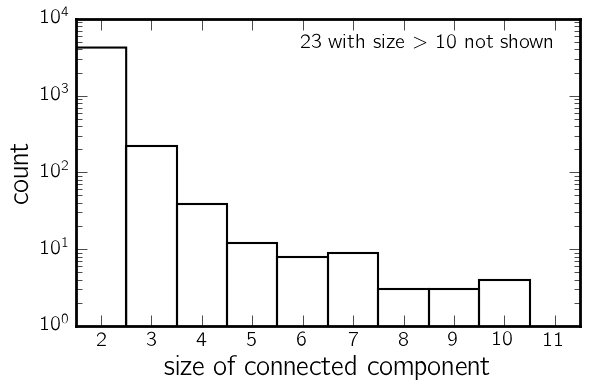

In [29]:
counts,_,_ = hist(sizes, bins=arange(1.5,10.6,1), log=True,
                  histtype='bar', color='k', facecolor='None', edgecolor='k', lw=1.5)
print(counts.sum())
xlim(1.5, 11.5)
xticks([2,3,4,5,6,7,8,9,10,11])
xlabel('size of connected component')
ylabel('count')
text(0.95, 0.95, '%i with size $>$ 10 not shown' % ((sizes>10).sum()),
     transform=gca().transAxes, va='top', ha='right', size=15)

# [i.set_linewidth(2) for i in gca().spines.values()]
# gca().tick_params(axis='both', which='major', size=8)
# gca().tick_params(axis='both', which='minor', size=4)
tight_layout()
savefig('../paper/figures/dist_networksize.pdf')

In [12]:
# sorted list of subgraphs from largest to smallest
Gc = array(sorted(nx.connected_component_subgraphs(graph), key=len, reverse=True))
sizes = array([len(g) for g in Gc])

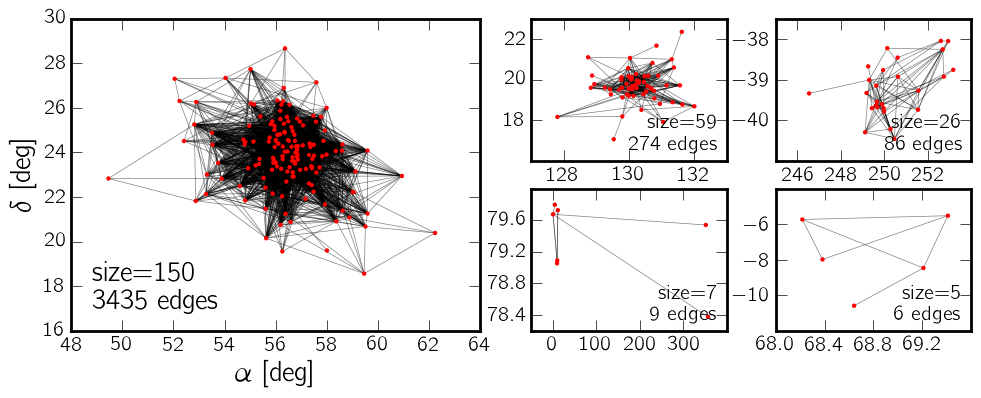

In [48]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.gridspec as gridspec

def set_line_alpha(ax):
    linecollection = ax.collections[1]
    linecollection.set_alpha(0.5)

fig = figure(figsize=(10,4))
fig.subplots_adjust(top=0.95, right=0.98, bottom=0.17, left=0.08)
ax0 = subplot(121)
g = Gc[0]
# pos = {node:(tgas.l[node], d[node]) for node in g.nodes()}
pos = {node:(tgas.ra.value[node], tgas.dec.value[node]) for node in g.nodes()}
nx.draw_networkx(g, pos=pos, node_size=10, width=.5, with_labels=False, alpha=1)
set_line_alpha(ax0)
xlabel(r'$\alpha$ [deg]')
ylabel(r'$\delta$ [deg]')
text(0.05, 0.05, 'size=%i\n%i edges' % (len(g), len(g.edges())),
     transform=gca().transAxes, va='bottom', ha='left', size=20)

grid = gridspec.GridSpec(2,2)
grid.update(left=0.54, right=0.98, wspace=0.25)
ax = [subplot(i) for i in grid]
for i, gi in enumerate([6,13,37,51]):
    g = Gc[gi]
#     pos = {node:(tgas.l[node], d[node]) for node in g.nodes()}
    pos = {node:(tgas.ra.value[node], tgas.dec.value[node]) for node in g.nodes()}
    nx.draw_networkx(g, pos=pos, node_size=10, width=.5, with_labels=False, ax=ax[i])
    ax[i].xaxis.set_major_locator(MaxNLocator(nbins=5,prune='both'))
    ax[i].yaxis.set_major_locator(MaxNLocator(nbins=5,prune='both'))
    ax[i].text(0.95, 0.05, 'size=%i\n%i edges' % (len(g), len(g.edges())),
               transform=ax[i].transAxes, va='bottom', ha='right', size=15)
    ax[i].tick_params(which='both', labelsize=15)
    set_line_alpha(ax[i])

ax[0].set_xticks([128, 130, 132])
# savefig('../paper/figures/graphviz_examples.pdf')
# savefig('../paper/figures/graphviz_examples.png', dpi=150)

In [ ]:
a = array(Gc[6].nodes())
plot(tgas.l[a], tgas.get_distance()[a], '.')
plot(mwsc['GLON'], mwsc['d'], 'ro')
for cl in mwsc[
    (mwsc['d']<d[a].max()) & (mwsc['d']>d[a].min()) & (mwsc['GLON']>tgas.l[a].min()) & (mwsc['GLON']<tgas.l[a].max())]:
    text(cl['GLON'], cl['d'], cl['Name'].replace('_', ' '))
xlim(tgas.l[a].min()*0.9, tgas.l[a].max()*1.1)
ylim(d[a].min()*0.9, d[a].max()*1.1)

In [14]:
mwsc = Table.read('../data/J_A+A_585_A101/catalog.dat', readme='../data/J_A+A_585_A101/ReadMe',
                 format='ascii.cds')
print('total number of mwsc', len(mwsc))
print('number of mwsc d<600 pc', (mwsc['d']<600).sum())

total number of mwsc 3210
number of mwsc d<600 pc 135


In [15]:
obass = Table.read('../data/J_AJ_117_354/tablec1.dat', readme='../data/J_AJ_117_354/ReadMe',
                    format='ascii.cds')
print('OB association stars', len(obass))

from astroquery.simbad import Simbad

# query simbad on HIP id's to get coordinates
customSimbad = Simbad()
customSimbad.add_votable_fields('sptype', 'parallax')
result = customSimbad.query_objects(['HIP %i' % hip for hip in obass['HIP']])
print( unique([s.decode("utf-8")[0] if len(s)>0 else '?' for s in result['SP_TYPE']]) )

def get_distance(parallax, parallax_error):
    """
    Return the distance [kpc] point estimate with the Lutz-Kelker correction
    
    parallax : float, in mas
    parallax_error : float, in mas
    """
    snr = parallax / parallax_error
    pnew = parallax * (0.5 + 0.5*np.sqrt(1 - 16./snr**2))
    # if snr<4, the value will be maksed
    return 1./pnew

obass_dist = get_distance(result['PLX_VALUE'], result['PLX_ERROR'])
obass_c = coords.SkyCoord(result['RA'], result['DEC'], unit=(u.hourangle, u.deg),
                          distance=obass_dist*u.kpc)
obass_cg = obass_c.transform_to(coords.Galactic)

OB association stars 1130
['?' 'A' 'B' 'C' 'F' 'G' 'K' 'M' 'O' 'W']


/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
figure(figsize=(10,5))

pairs = array([list(g.nodes()) for g in Gc[sizes==2]])
x = hstack([tgas.l[pairs], array([None]*pairs.shape[0])[:,None]])
y = hstack([d[pairs], array([None]*pairs.shape[0])[:,None]])
# manipulate GLON
x[:,:-1].sort(axis=1)
x[:,1][x[:,1]-x[:,0]>180] -= 360.
plot(x.ravel(),y.ravel(), alpha=.3, c='k', label='size 2')

pairs = array([list(g.nodes()) for g in Gc[sizes==3]])
x = hstack([tgas.l[pairs], array([None]*pairs.shape[0])[:,None]])
y = hstack([d[pairs], array([None]*pairs.shape[0])[:,None]])
# manipulate GLON
x[:,:-1].sort(axis=1)
for i in range(x.shape[1]-1):
    x[:,i][x[:,i]-x[:,0]>180] -= 360.
plot(x.ravel(), y.ravel(), alpha=.7, c='b', label='size 3')

for s in Gc[sizes>=4]:
    plot(tgas.l[s], d[s], '.', c=cm.spectral(uniform()))
    
for cc, ll in mwsc['d', 'GLON'][mwsc['d']<600]:
    l, = plot(ll, cc, 'ro', ms=8, mfc='None', mec='k', mew=1,)
    
xlim(0,360)
ylim(0,500)
# leg = legend(loc='upper left')

xlabel('Galactic longtidude [deg]')
ylabel('distance [pc]')

In [ ]:
# figure(figsize=(10,5))
figure(figsize=(10,10))
ax = subplot(111, projection='polar')
pairs = array([list(g.nodes()) for g in Gc[sizes==2]])
x = hstack([deg2rad(tgas.l[pairs]), array([None]*pairs.shape[0])[:,None]])
y = hstack([d[pairs], array([None]*pairs.shape[0])[:,None]])
# manipulate GLON
x[:,:-1].sort(axis=1)
x[:,1][x[:,1]-x[:,0]>180] -= 360.
plot(x.ravel(),y.ravel(), alpha=.3, c='k', label='size 2')

pairs = array([list(g.nodes()) for g in Gc[sizes==3]])
x = hstack([deg2rad(tgas.l[pairs]), array([None]*pairs.shape[0])[:,None]])
y = hstack([d[pairs], array([None]*pairs.shape[0])[:,None]])
# manipulate GLON
x[:,:-1].sort(axis=1)
for i in range(x.shape[1]-1):
    x[:,i][x[:,i]-x[:,0]>180] -= 360.
plot(x.ravel(), y.ravel(), alpha=.7, c='b', label='size 3')


for s in Gc[sizes>=4]:
    plot(deg2rad(tgas.l[s]), d[s], '.', c=cm.spectral(uniform()))
    
for cc, ll in mwsc['d', 'GLON'][mwsc['d']<600]:
    l, = plot(deg2rad(ll), cc, 'ro', ms=8, mfc='None', mec='k', mew=1,)
    
ylim(0,250)
yticks([100,200])

tight_layout()


In [98]:
sum(sizes>5)

50

/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(<a list of 16 Line2D ticklines objects>,
 <a list of 8 Text major ticklabel objects>)

/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/projections/polar.py:65: RuntimeWarning: invalid value encountered in less
  mask = r < 0


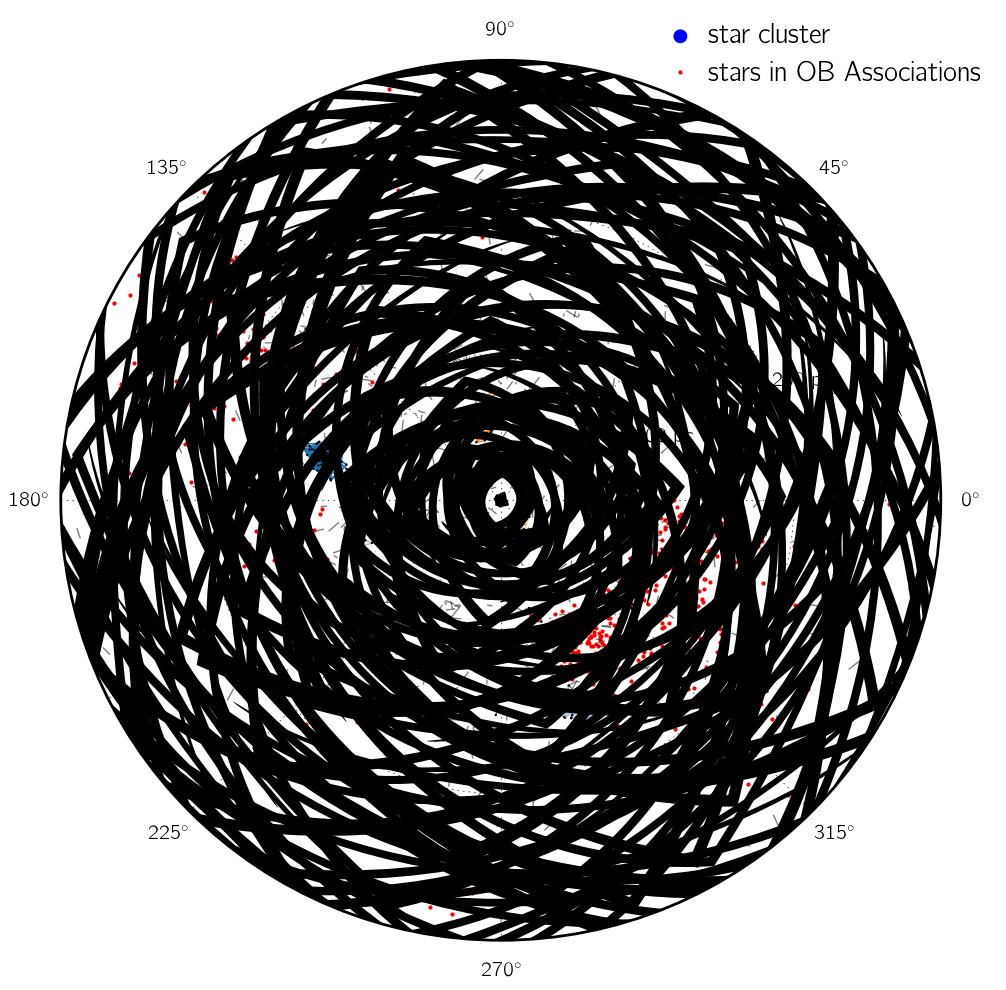

In [59]:
import palettable
from itertools import cycle
colorloop = cycle(palettable.tableau.Tableau_20.hex_colors)

fig = figure(figsize=(10,10))
fig.subplots_adjust(top=0.95,bottom=0.04,right=0.93,left=0.05)

ax = subplot(111, projection='polar')
ax.set_color_cycle(palettable.tableau.Tableau_20.mpl_colors)

for g in Gc[::5]:
    if len(g) > 5:
        pos = {node:(deg2rad(tgas.l[node]), d[node]*cos(deg2rad(tgas.b[node]))) for node in g.nodes()}
        nx.draw_networkx(g, pos=pos, node_size=3, width=1, with_labels=False,
#                          edge_color=mpl.colors.rgb2hex(cm.spectral(random.uniform())),
                         edge_color=next(colorloop),
                         node_color='k')
    else:
        pos = {node:(deg2rad(tgas.l[node]), d[node]*cos(deg2rad(tgas.b[node]))) for node in g.nodes()}
        nx.draw_networkx_edges(g, pos=pos, width=1, with_labels=False,
                               edge_color='k',alpha=.5)
        
# for cc, ll, bb in mwsc['d', 'GLON', 'GLAT'][mwsc['d']<600]:
#     h1, = plot(deg2rad(ll), cc*cos(deg2rad(bb)), 'o', ms=15,
#                mfc='#428bca', mec='#428bca', mew=1.5, alpha=.6)
mwsc_close = mwsc[mwsc['d']<600]
dx = 5
clustercircles = [Circle((R*cos(theta), R*sin(theta)), dx,) for theta, R in
                  zip(mwsc_close['GLON'], mwsc_close['d']*cos(deg2rad(mwsc_close['GLAT'])))]
[ax.add_patch(cc) for cc in clustercircles]
# dx_in_points = np.diff(ax.transData.transform((0, dx)))[0]
# h1 = ax.scatter(deg2rad(mwsc_close['GLON']),
#                  mwsc_close['d']*cos(deg2rad(mwsc_close['GLAT'])),
#                  facecolors='#428bca', alpha=.6, linewidth=1.5, s=dx_in_points**2)

h2, = ax.plot(obass_cg.l.to(u.rad).value, obass_dist*1000*cos(obass_cg.b.to(u.rad).value),
              c='r', marker='.', ls='None', zorder=-100)

figlegend((h1,h2), ('star cluster', 'stars in OB Associations'), 'upper right',
    numpoints=1, frameon=False, fontsize=20,
    handletextpad=0, markerscale=1, scatterpoints=1)
ylim(0,300)
yticks([100,200,], ['100 pc', '200 pc'])
# ax.set_theta_direction(-1)
ax.set_theta_zero_location('E')
ax.set_thetagrids(arange(0,360,45), frac=1.07)

# savefig('../paper/figures/glon_d_pie.png', dpi=150)
# savefig('../paper/figures/glon_d_pie.pdf', dpi=150)

# close()

In [90]:
gx, gy, gz = c.transform_to(coords.Galactic).cartesian.xyz.value

/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/astropy/coordinates/angles.py:625: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/astropy/coordinates/angles.py:513: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/astropy/coordinates/angles.py:513: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/astropy/coordinates/angles.py:625: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):


In [87]:
mwsc_cg = coords.SkyCoord(
    mwsc['GLON'], mwsc['GLAT'], mwsc['d'].data, unit=(u.deg,u.deg,u.pc),
    frame='galactic')

In [109]:
matplotlib.__version__

'1.5.1'

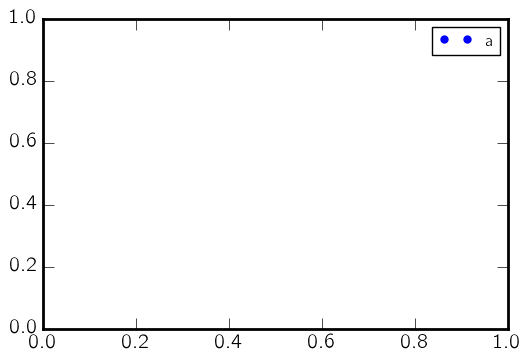

In [112]:
# h1, = plot([0],[0], mfc='#428bca', marker='o', ms=50)
h1 = Line2D((0,1), (0,0), marker='o', linestyle='')

gca().legend((h1,), ('abc'))

/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


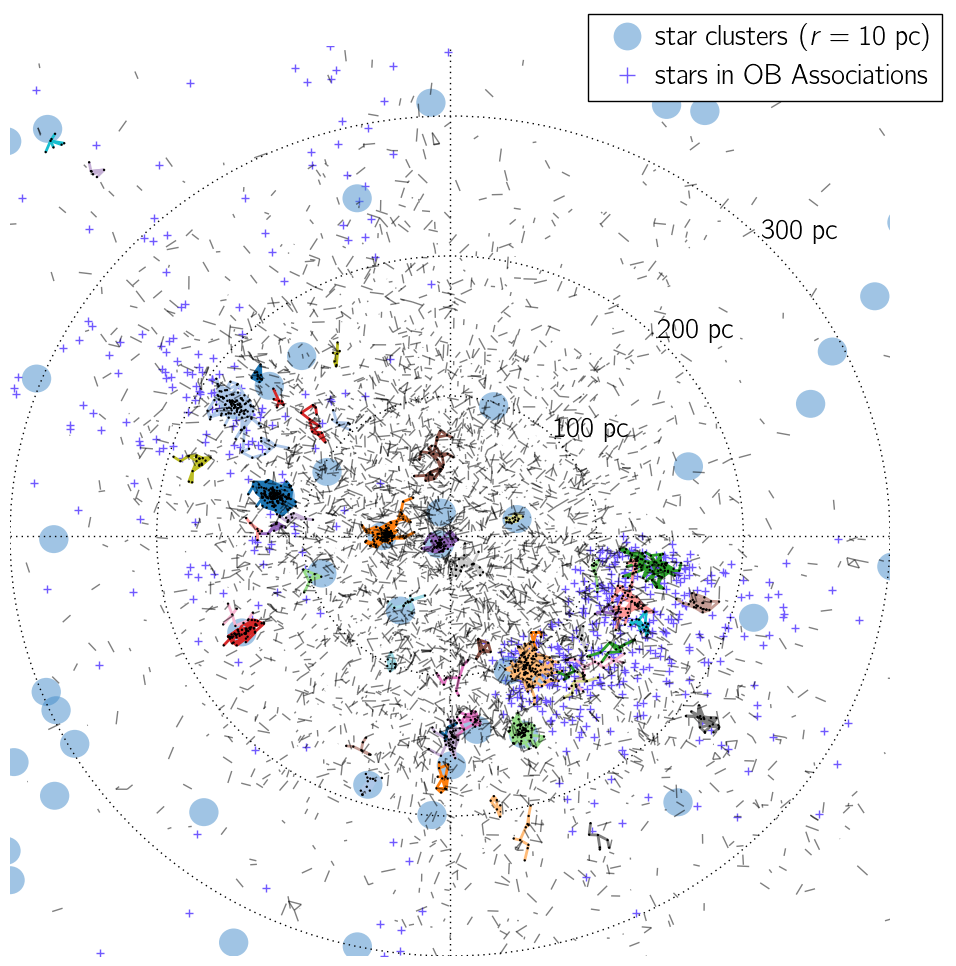

In [131]:
import palettable
from itertools import cycle
colorloop = cycle(palettable.tableau.Tableau_20.hex_colors)

fig = figure(figsize=(10,10))
fig.subplots_adjust(top=0.95,bottom=0.04,right=0.93,left=0.05)

ax = subplot(111)
ax.set_color_cycle(palettable.tableau.Tableau_20.mpl_colors)

mwsc_close = mwsc[mwsc['d']<600]
dx = 10
clustercircles = [Circle((tmp.x.value, tmp.y.value), dx, zorder=-50,
                         facecolor='#428bca', alpha=.5)
                  for tmp in mwsc_cg.cartesian]
[ax.add_patch(cc) for cc in clustercircles]

h2, = ax.plot(obass_cg.cartesian.x.to(u.pc).value,
              obass_cg.cartesian.y.to(u.pc).value,
              c='b', mec='#7059ff', mew=1., marker='+', ls='None', zorder=-100)
h1 = Line2D((0,1), (0,0), marker='o', linestyle='', ms=10, mfc='#428bca', alpha=.5)

for g in Gc[::]:
    if len(g) > 5:
        pos = {node:(gx[node], gy[node])
               for node in g.nodes()}
        nx.draw_networkx(g, pos=pos, node_size=3, width=2, with_labels=False,
#                          edge_color=mpl.colors.rgb2hex(cm.spectral(random.uniform())),
                         edge_color=next(colorloop),
                         node_color='k')
    else:
        pos = {node:(gx[node], gy[node])
               for node in g.nodes()}
        nx.draw_networkx_edges(g, pos=pos, width=1, with_labels=False,
                               edge_color='k',alpha=.5)
        



legend = figlegend((h1, h2), ('star clusters ($r=10$ pc)', 'stars in OB Associations'), 'upper right',
    numpoints=1, frameon=True, fontsize=20,
    handletextpad=0, markerscale=2, scatterpoints=1, )
legend.get_frame().set_facecolor('white')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

gridcircles = [Circle((0, 0), r, facecolor='None', linestyle='dotted', ec='k')
               for r in [100, 200, 300]]
[ax.add_patch(cc) for cc in gridcircles]
[ax.text(r*cos(pi/4), r*sin(pi/4), '%.0f pc' % (r), size=20) for r in [100,200,300]]

ax.axhline(0., c='k', ls='dotted')
ax.axvline(0., c='k', ls='dotted')

ax.set_xlim(-300,300)
ax.set_ylim(-300,350)

savefig('../paper/figures/glon_d_pie.pdf', dpi=150, )

# close()

# X-Z plane

In [32]:
co = tgas.get_coord()

/Users/semyeong/projects/gaia-wide-binaries/gwb/data.py:102: RuntimeWarning: invalid value encountered in sqrt
  tmp = self._data['parallax'] * (0.5 + 0.5*np.sqrt(1 - 16/snr**2))


In [33]:
cog = co.transform_to(coords.Galactic)

/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/astropy/coordinates/angles.py:656: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/astropy/coordinates/angles.py:547: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/astropy/coordinates/angles.py:547: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/astropy/coordinates/angles.py:656: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):


In [34]:
gx,gy,gz = cog.cartesian.xyz.value
gR = hypot(gx,gy)

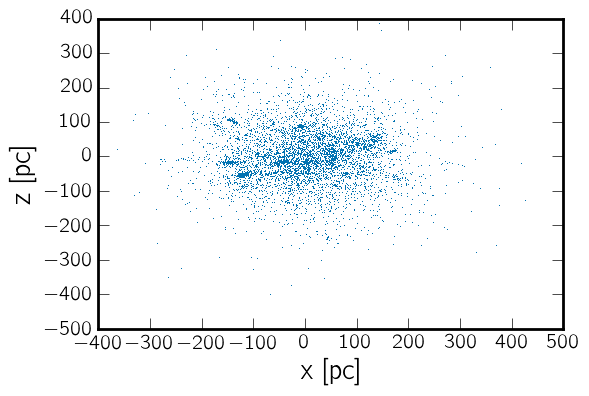

In [16]:
# plot(gx[:], gz[:], ',')
plot(gx[cmpairs['star1']], gz[cmpairs['star1']], ',')
# plot(gx[cmpairs['star2']], gz[cmpairs['star2']], ',')
xlabel('x [pc]')
ylabel('z [pc]')
# ylim(-300,300)
# axhline(0, c='k', lw=.5)
# axvline(0, c='k', lw=.5)

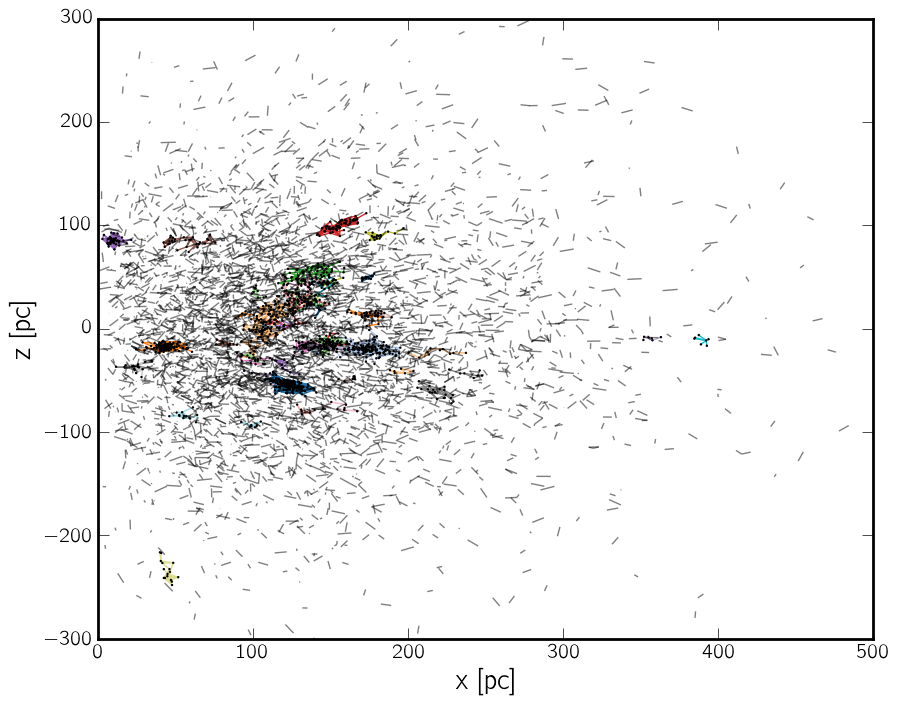

In [64]:

import palettable
from itertools import cycle

colorloop = cycle(palettable.tableau.Tableau_20.hex_colors)

fig = figure(figsize=(10,8))
# fig.subplots_adjust(top=0.95,bottom=0.04,right=0.93,left=0.05)

ax = subplot(111,)
for g in Gc[::]:
    if len(g) > 5:
        pos = {node:(hypot(gx[node], gy[node]), gz[node]) for node in g.nodes()}
        nx.draw_networkx(g, pos=pos, node_size=3, width=1, with_labels=False,
                         edge_color=next(colorloop),
                         node_color='k')
    else:
        pos = {node:(hypot(gx[node], gy[node]), gz[node]) for node in g.nodes()}
        nx.draw_networkx_edges(g, pos=pos, width=1, with_labels=False,
                               edge_color='k',alpha=.5)
# c_mwsc = coords.SkyCoord(mwsc['GLON'], mwsc['GLAT'], distance=mwsc['d'], frame=coords.Galactic) 
# for c in c_mwsc[c_mwsc.distance.value<600]:
#     h1, = plot(c.cartesian.xyz.value[0], c.cartesian.xyz.value[2], 'ro', ms=8, mfc='None', mec='m', mew=1,)

# legend((h1,), ('star cluster',), loc='upper right',
#        numpoints=1, frameon=False, fontsize=20,handletextpad=0, markerscale=2)
ylim(-300,300)
xlim(0,500)
xlabel('x [pc]')
ylabel('z [pc]')

# savefig('../paper/figures/x_z.pdf')

In [54]:
sepvec = []
for g in Gc[sizes==2]:
    n1, n2 = g.nodes()
    sepvec.append((gx[n2]-gx[n1], gy[n2]-gy[n1], gz[n2]-gz[n1]))

In [55]:
sepvec = atleast_2d(sepvec)

In [47]:
sepvec = sepvec / norm(sepvec, axis=1)[:,newaxis]

(array([   4.,    8.,   11.,   18.,   22.,   25.,   25.,   23.,   31.,
          46.,   53.,   43.,   55.,   68.,   78.,   62.,   62.,   74.,
          77.,   85.,   93.,   86.,   93.,  103.,   87.,   99.,  109.,
         118.,   87.,  105.,  108.,   99.,  118.,   98.,  117.,  118.,
         100.,   98.,   99.,  103.,  104.,  103.,   88.,   97.,   90.,
          76.,   78.,   67.,   80.,   68.,   63.,   52.,   57.,   47.,
          56.,   39.,   41.,   30.,   31.,   20.,   16.,   13.,    4.,    8.]),
 array([-87.29305787, -84.53937009, -81.7856823 , -79.03199451,
        -76.27830673, -73.52461894, -70.77093115, -68.01724337,
        -65.26355558, -62.5098678 , -59.75618001, -57.00249222,
        -54.24880444, -51.49511665, -48.74142886, -45.98774108,
        -43.23405329, -40.4803655 , -37.72667772, -34.97298993,
        -32.21930214, -29.46561436, -26.71192657, -23.95823879,
        -21.204551  , -18.45086321, -15.69717543, -12.94348764,
        -10.18979985,  -7.43611207,  -4.682424

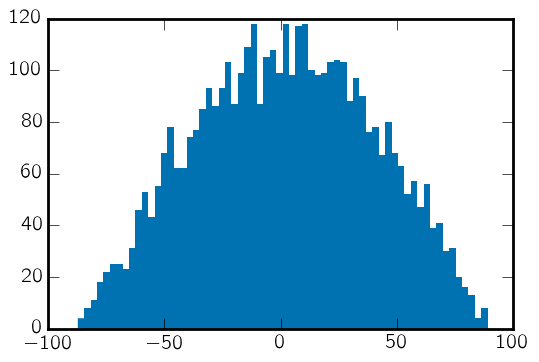

In [59]:
hist(rad2deg(arctan(sepvec[:,2]/ norm(sepvec[:,:2], axis=1))), 64)

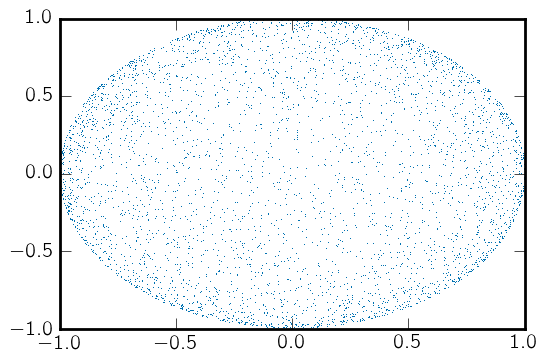

In [51]:
plot(sepvec[:,0], sepvec[:,1], ',')

(array([  11.,   15.,   30.,   49.,   65.,   75.,   98.,  104.,  131.,
         138.,  141.,  169.,  192.,  201.,  226.,  328.,  427.,  265.,
         223.,  191.,  181.,  177.,  138.,  138.,  113.,   98.,   79.,
          77.,   59.,   51.,   29.,   17.]),
 array([-9.90297409, -9.28655889, -8.67014369, -8.05372849, -7.43731329,
        -6.82089809, -6.20448289, -5.58806769, -4.97165249, -4.35523728,
        -3.73882208, -3.12240688, -2.50599168, -1.88957648, -1.27316128,
        -0.65674608, -0.04033088,  0.57608432,  1.19249953,  1.80891473,
         2.42532993,  3.04174513,  3.65816033,  4.27457553,  4.89099073,
         5.50740593,  6.12382113,  6.74023633,  7.35665154,  7.97306674,
         8.58948194,  9.20589714,  9.82231234]),
 <a list of 32 Patch objects>)

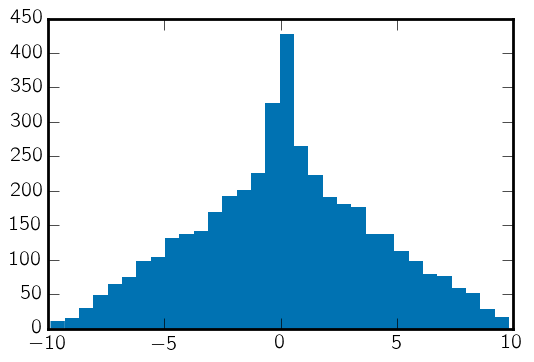

In [40]:
hist(diffz, 32)

(0, 120)

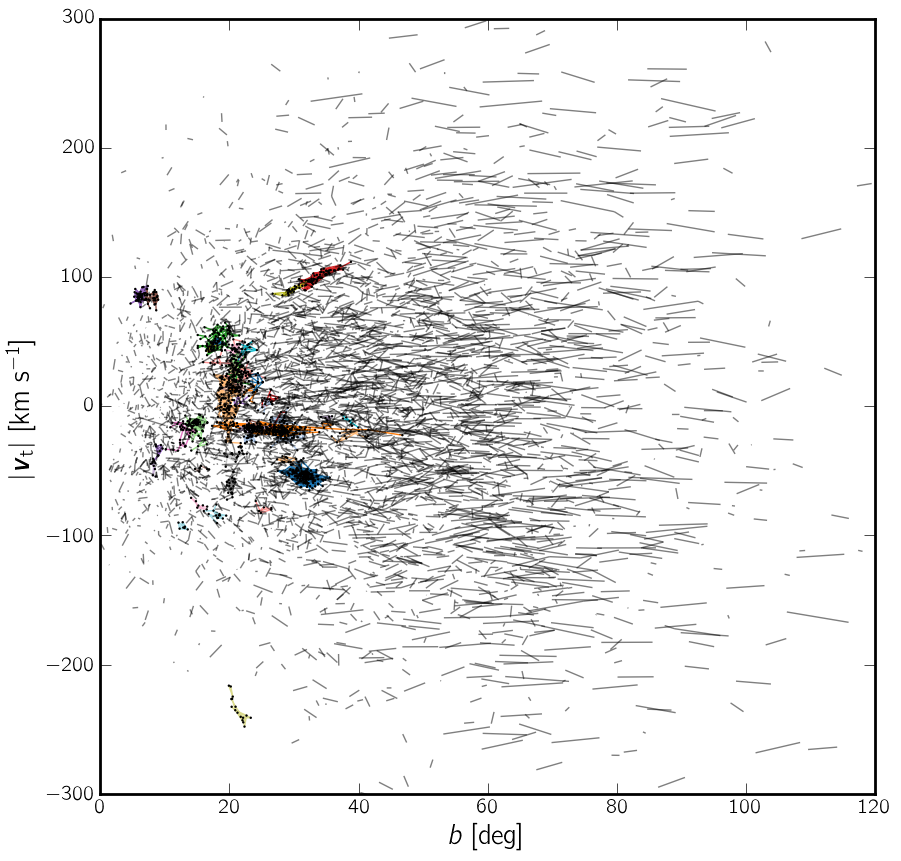

In [109]:
colorloop = cycle(palettable.tableau.Tableau_20.hex_colors)

fig = figure(figsize=(10,10))
# fig.subplots_adjust(top=0.95,bottom=0.04,right=0.93,left=0.05)

ax = subplot(111,)
for g in Gc[::]:
    if len(g) > 5:
        pos = {node:(norm(vtan[node]), gz[node]) for node in g.nodes()}
        nx.draw_networkx(g, pos=pos, node_size=3, width=1, with_labels=False,
                         edge_color=next(colorloop),
                         node_color='k')
    else:
        pos = {node:(norm(vtan[node]), gz[node]) for node in g.nodes()}
        nx.draw_networkx_edges(g, pos=pos, width=1, with_labels=False,
                               edge_color='k',alpha=.5)
# ylim(0,)
xlabel('$b$ [deg]')
ylabel(r'$|\boldsymbol{v}_{\rm{t}}|$ [km s$^{-1}$]')
# savefig('../paper/figures/b_vt.pdf')
ylim(-300,300)
xlim(0,120)
# xlabel('x [pc]')
# ylabel('z [pc]')

# RAVE Cross-match

In [12]:
rave = Table.read('../data/tgas_rave_RV.fits')

In [51]:
matched_rave = ~rave['row_id'].mask
print('total number of tgas+rave matches', matched_rave.sum())

hrv = rave['HRV']
ehrv = rave['eHRV'].data

# rv1 = hrv[pairidx['star1']]
# rv2 = hrv[pairidx['star2']]
# drv = rv1 - rv2
# edrv = hypot(ehrv[pairidx['star1']], ehrv[pairidx['star2']])
# matched_rave1 = matched_rave[pairidx['star1']]
# matched_rave2 = matched_rave[pairidx['star2']]
# matched_rave12 = matched_rave1 & matched_rave2

total number of tgas+rave matches 210368


In [31]:
star1 = cmpairs['star1']
star2 = cmpairs['star2']
nsize = array([len(nx.node_connected_component(graph, s1)) for s1 in star1])

In [53]:
((nsize==2) & (cmpairs['sep']>3)).sum()

3507

In [54]:
drv = hrv[star1] - hrv[star2]
edrv = hypot(ehrv[star1], ehrv[star2])
drv_edrv = drv/edrv
cmrave = matched_rave[star1] & matched_rave[star2]

/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


In [55]:
print('number of pairs with RAVE', prod(matched_rave[vstack([star1,star2]).T], axis=1).sum())
print('number of mutually exclusive pairs with RAVE',
      prod(matched_rave[vstack([star1,star2]).T[nsize==2]], axis=1).sum())

number of pairs with RAVE 290
number of mutually exclusive pairs with RAVE 203


In [ ]:
unique(nsize[cmrave])

In [57]:
import pandas as pd

In [58]:
from scipy import interpolate

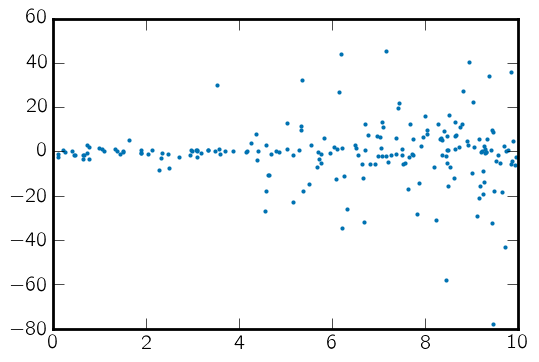

In [24]:
plot(cmpairs['sep'][cmrave & (nsize==2)], drv_edrv[cmrave & (nsize==2)], '.')
# ylim(-20,20)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  4.,  0.,  6.,  3.,
         1.,  6.,  1.,  2.,  2.,  1.]),
 array([-58.04032135, -55.72319561, -53.40606987, -51.08894414,
        -48.7718184 , -46.45469266, -44.13756692, -41.82044119,
        -39.50331545, -37.18618971, -34.86906397, -32.55193824,
        -30.2348125 , -27.91768676, -25.60056102, -23.28343529,
        -20.96630955, -18.64918381, -16.33205807, -14.01493233,
        -11.6978066 ,  -9.38068086,  -7.06355512,  -4.74642938,
         -2.42930365,  -0.11217791,   2.20494783,   4.52207357,
          6.8391993 ,   9.15632504,  11.47345078,  13.79057652,  16.10770226]),
 <a list of 32 Patch objects>)

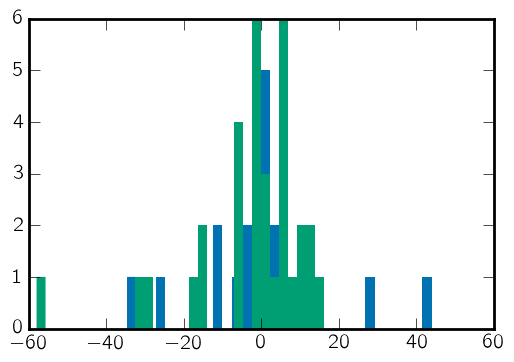

In [30]:
hist(drv_edrv[cmrave & (nsize==2) & (fabs(cmpairs['sep']-6) < 0.5)], 32)
hist(drv_edrv[cmrave & (nsize==2) & (fabs(cmpairs['sep']-8) < 0.5)], 32)

NameError: name 'cmrave' is not defined

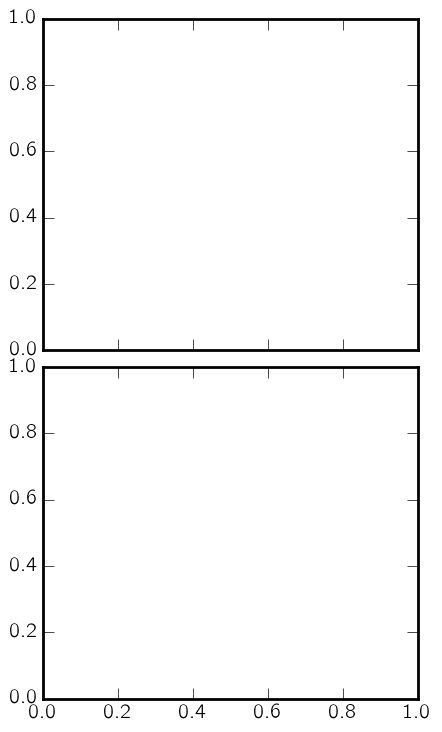

In [33]:
# colors for two groups
color_size2 = '#d95f02'
color_sizelt2 = '#1b9e77'

fig, ax = subplots(2, 1, figsize=(5, 8), sharex=True)
fig.subplots_adjust(top=0.93, hspace=0.05, left=0.2, bottom=0.08, right=0.95)
suptitle('%i pairs with RAVE RV' % cmrave.sum(), size=20, x=0.55)

sca(ax[0])
errorbar(cmpairs['sep'][cmrave & (nsize==2)], drv_edrv[cmrave & (nsize==2)],
         fmt='.',color=color_size2, label='size=2 (mutually exclusive)')
errorbar(cmpairs['sep'][cmrave & (nsize>2)], drv_edrv[cmrave & (nsize>2)],
         fmt='^', mew=1, ms=4, mec=color_sizelt2, mfc='None', label='size$>$2',)
axhline(-3, color='gray')
axhline(3, color='gray')
ylim(-20,20)
# xscale('log')
xlim(0,10)
ylabel('$\Delta v_r/\sigma_{\Delta v_r}$')

legend(loc=(-0.03,0.75), frameon=False, numpoints=1, markerscale=2, fontsize=15, handletextpad=0)

sca(ax[1])
n=15  # each bin contains 2n+1 data points

tmpsep = pd.Series(cmpairs['sep'][cmrave & (nsize==2)].astype('<f8'))
bool3 = pd.Series((drv_edrv<3)[cmrave & (nsize==2)].astype('<f8'))
isort = tmpsep.argsort()
tmpsep_sort = tmpsep[isort]
bool3_sort = bool3[isort]
rollsep = tmpsep_sort.rolling(2*n+1, center=True)
rollbool = bool3_sort.rolling(2*n+1, center=True)
errors = vstack([
    rollsep.median() - rollsep.min(),
    rollsep.max() - rollsep.median()]).T[n:-n]

errorbar(rollsep.median()[n:-n], rollbool.mean()[n:-n],
         xerr=errors.T, fmt='.', color=color_size2)

# fit spline
# x = log10(rollsep.median()[n:-n])
# y = rollbool.mean()[n:-n]
# tck = interpolate.splrep(x, y, s=1, k=3)
# xnew = logspace(-1, 1)
# ynew = interpolate.splev(log10(xnew), tck, der=0, ext=3)
# plot(xnew, ynew, 'b.-')

tmpsep = pd.Series(cmpairs['sep'][cmrave & (nsize>2)].astype('<f8'))
bool3 = pd.Series((drv_edrv<3)[cmrave & (nsize>2)].astype('<f8'))
isort = tmpsep.argsort()
tmpsep_sort = tmpsep[isort]
bool3_sort = bool3[isort]
rollsep = tmpsep_sort.rolling(2*n+1, center=True)
rollbool = bool3_sort.rolling(2*n+1, center=True)
errors = vstack([
    rollsep.median() - rollsep.min(),
    rollsep.max() - rollsep.median()]).T[n:-n]
errorbar(rollsep.median()[n:-n], rollbool.mean()[n:-n],
         xerr=errors.T, fmt='^', mew=1, ms=4, mec=color_sizelt2, mfc='None', ecolor=color_sizelt2, capsize=0)

# xscale('log')
ylim(0.,1.05)
xlim(0,10)
xlabel('separation [pc]')
ylabel('$f(|\Delta v_r/\sigma_{\Delta v_r}| < 3)$')
# savefig('../paper/figures/raverv.pdf')

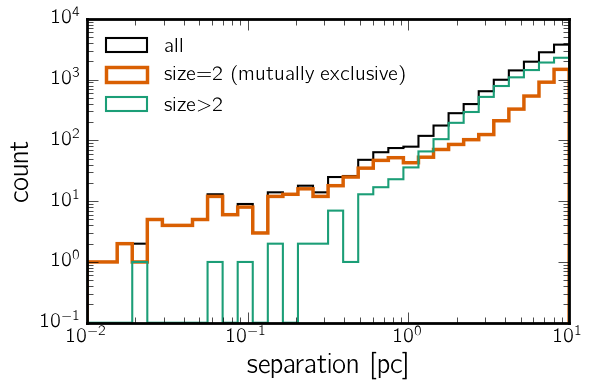

In [39]:
from astropy import stats as astats
binsize = astats.knuth_bin_width(log10(cmpairs['sep']))
bins = logspace(-2,1,3/binsize)

c,bins,patches = hist(cmpairs['sep'], bins, log=True, histtype='step',
                      label='all', color='k', lw=1.5)
_ = hist(cmpairs['sep'][nsize==2], bins, log=True, histtype='step',
         label='size=2 (mutually exclusive)', lw=2.5, color=color_size2)
_ = hist(cmpairs['sep'][nsize>2], bins, log=True, histtype='step', label='size$>$2', color=color_sizelt2,
         lw=1.5)
ylabel('count')
xlabel('separation [pc]')
legend(loc='upper left', fontsize=15, frameon=False)
tight_layout()
xscale('log')
savefig('../paper/figures/hist_sep.pdf')

In [ ]:

counts, edges = histogram(log10(cmpairs['sep'][nsize==2]), 32, )
centers = (edges[1:]+edges[:-1])*0.5
ynew = interpolate.splev(centers, tck, der=0, ext=3)
plot(centers, counts, 'ko-')
plot(centers, counts*ynew, 'bo-')
yscale('log')

# Color-Magnitude Diagrams

In [13]:
tmass = fits.getdata('/Users/semyeong/data/gaia/tgas_source/tgas-matched-2mass.fits')

In [14]:
tmass = fits.getdata('../data/tgas_tmassj.fits', ext=1)

In [61]:
isnan(tmass['j_m']).sum()

11280

In [15]:
gjcolor = tgas._data['phot_g_mean_mag']- tmass['j_m']
gMag = tgas._data['phot_g_mean_mag'] + 5*(log10(tgas._data['parallax']*1e-3)+1)

/Users/semyeong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


In [63]:
# distance matching sample
ind_uniq = unique(hstack([cmpairs['star1'], cmpairs['star2']]))
print(ind_uniq.size)
dpairs = d[ind_uniq]

10373


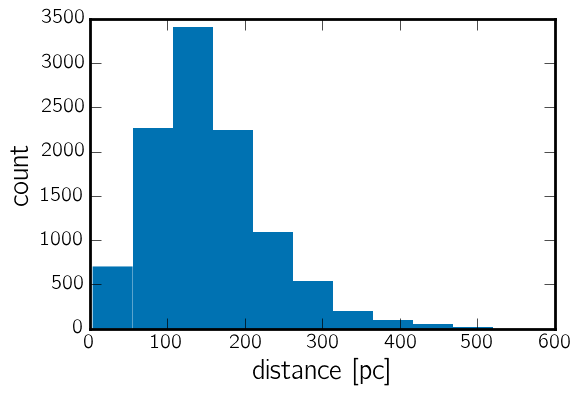

In [53]:
hist(dpairs)
xlabel('distance [pc]')
ylabel('count')

In [64]:
from sklearn.neighbors import KDTree

In [65]:
cond = (parallax_snr>8) & ~isnan(tmass['j_m'])
d_snr = d[cond]
ind_snr = arange(len(tgas))[cond]
dtree = KDTree(atleast_2d(d_snr).T)

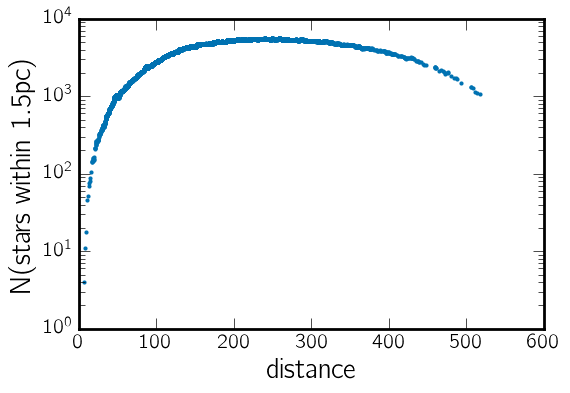

In [66]:
plot(dpairs, dtree.query_radius(atleast_2d(dpairs).T, 1.5, count_only=True), '.')
yscale('log')
xlabel('distance')
ylabel('N(stars within 1.5pc)')

In [67]:
N_per_star = 10
result = dtree.query_radius(atleast_2d(dpairs).T, 1.5,)

In [68]:
ind_control = []
for row in result:
    if len(row)==0:
        continue
    ind_control.append(ind_snr[choice(row, size=N_per_star)])
ind_control = hstack(ind_control)

In [60]:
d[ind_control]

array([ 134.07531408,  135.79533522,  136.09822497, ...,   50.03744712,
         50.62207481,   50.36591765])

(array([  1.27816212e-03,   4.12982618e-03,   6.21546969e-03,
          4.09621918e-03,   1.99432011e-03,   9.83370226e-04,
          3.79722641e-04,   1.73149141e-04,   8.73051575e-05,
          2.94061305e-05]),
 array([   3.49184748,   55.12620241,  106.76055735,  158.39491228,
         210.02926721,  261.66362214,  313.29797707,  364.932332  ,
         416.56668693,  468.20104186,  519.83539679]),
 <a list of 1 Patch objects>)

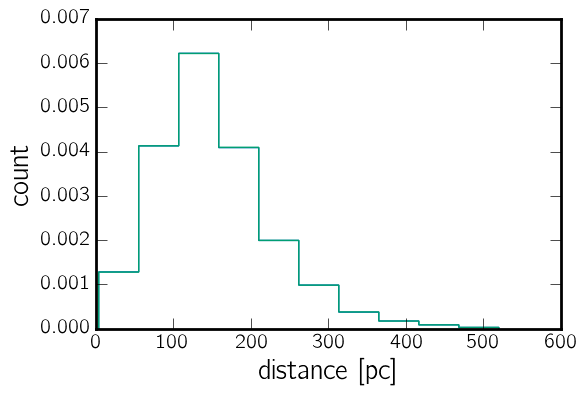

In [61]:
c,bins,patches=hist(dpairs, normed=True, histtype='step')
xlabel('distance [pc]')
ylabel('count')
hist(d[ind_control], bins=bins, normed=True, histtype='step')

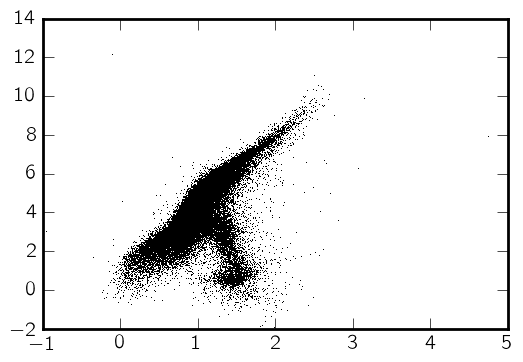

In [62]:
plot(gjcolor[ind_control], gMag[ind_control], 'k,')

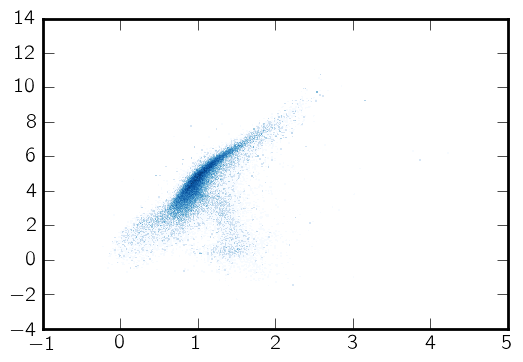

In [69]:
c, ye, xe = histogram2d(gjcolor[ind_control], gMag[ind_control], 512,)
x,y = meshgrid((xe[1:]+xe[:-1])*0.5, (ye[1:]+ye[:-1])*0.5)
pcolormesh(y,x,c, norm=mpl.colors.LogNorm(), cmap='Blues', zorder=-1)


In [70]:
def draw_cmd():
    c, ye, xe = histogram2d(gjcolor[ind_control], gMag[ind_control], 512,)
    x,y = meshgrid((xe[1:]+xe[:-1])*0.5, (ye[1:]+ye[:-1])*0.5)
    pcolormesh(y,x,c, norm=mpl.colors.LogNorm(), cmap='Blues', zorder=-1, rasterized=True)


[(8, -1), (8, -1), (8, -1), (8, -1)]

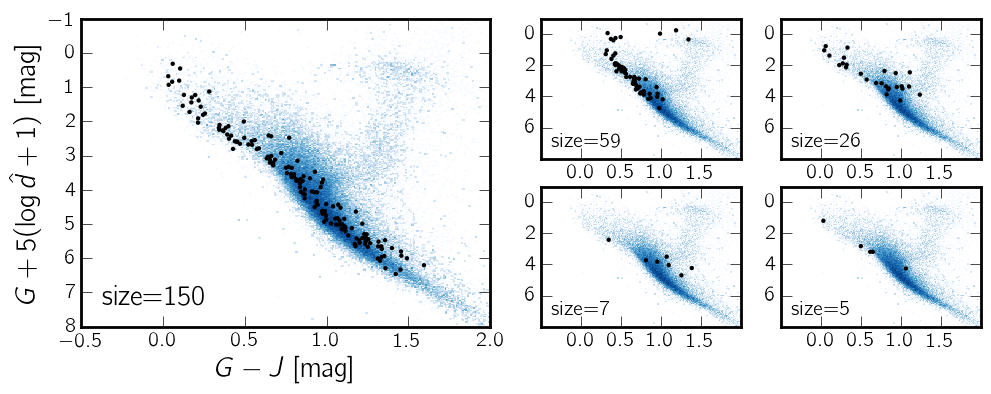

In [71]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.gridspec as gridspec

fig = figure(figsize=(10,4))
fig.subplots_adjust(top=0.95, right=0.98, bottom=0.18, left=0.08)
ax0 = subplot(121)
g = Gc[0]
pos = {node:(gjcolor[node],gMag[node]) for node in g.nodes()}
nx.draw_networkx(g, pos=pos, node_size=10, width=0, with_labels=False, node_color='k')
xlabel(r'$G-J$ [mag]')
ylabel(r'$G + 5(\log \hat d +1)$ [mag]')
text(0.05, 0.05, 'size=%i' % (len(g)),
     transform=gca().transAxes, va='bottom', ha='left', size=20)
draw_cmd()
ax0.set_xlim(-0.5, 2)
ax0.set_ylim(8,-1)

grid = gridspec.GridSpec(2,2)
grid.update(left=0.54, right=0.98)
ax = [subplot(i,) for i in grid]
for i, gi in enumerate([6,13,37,51]):
    g = Gc[gi]
    sca(ax[i])
    pos = {node:(gjcolor[node],gMag[node]) for node in g.nodes()}
    nx.draw_networkx(g, pos=pos, node_size=10, width=0, with_labels=False, ax=ax[i], node_color='k')
    ax[i].xaxis.set_major_locator(MaxNLocator(nbins=5,prune='both'))
    ax[i].yaxis.set_major_locator(MaxNLocator(nbins=5,prune='both'))
    ax[i].text(0.05, 0.05, 'size=%i' % (len(g)), size=15,
               transform=ax[i].transAxes, va='bottom', ha='left')
    ax[i].tick_params(which='both', labelsize=15)
    draw_cmd()

[a.set_xlim(-0.5,2.) for a in ax]
[a.set_ylim(8,-1) for a in ax]
# savefig('../paper/figures/gjg_graphviz_examples.pdf')
# savefig('../paper/figures/gjg_graphviz_examples.png', dpi=150)

In [ ]:
(mepairs['sep']<1).sum()

4236


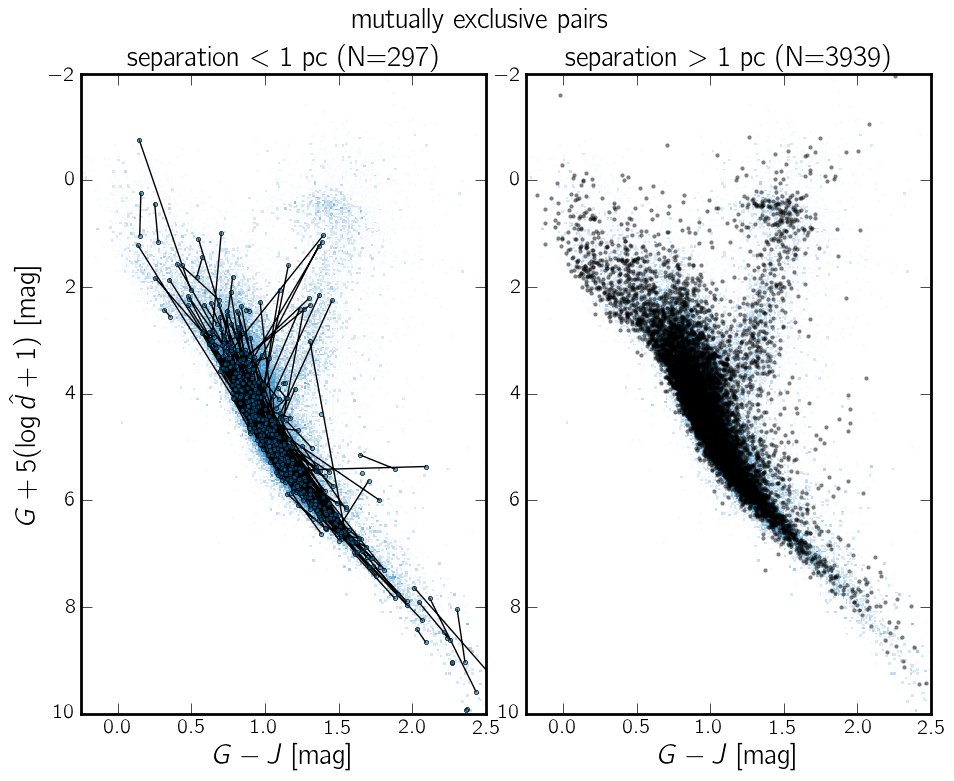

In [112]:
fig, ax = subplots(1,2, figsize=(10,8))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, wspace=0.1)
suptitle('mutually exclusive pairs', size=20)

nsize = array([len(nx.node_connected_component(graph, s1)) for s1 in cmpairs['star1']])
mepairs = cmpairs[(nsize==2)]
print(mepairs.size)

star1,star2 = mepairs['star1'], mepairs['star2']
gj1, gj2 = gjcolor[star1], gjcolor[star2]
g1, g2 = gMag[star1], gMag[star2]

x = vstack([gj1,gj2,[None]*gj1.size]).T
y = vstack([g1,g2,[None]*g1.size]).T

sepdivide = 1  # pc

sca(ax[0])
draw_cmd()
l, = plot(x[mepairs['sep']<sepdivide].ravel(),y[mepairs['sep']<sepdivide].ravel(),
     'ko-', lw=1., mec='k', mew=0.5, ms=3, mfc='#0072B2')#, rasterized=True)
l.set_markerfacecolor((0, 114/256., 178/256., 0.5))

xlim(-.25,2.5)
ylim(10,-2)

xlabel(r'$G-J$ [mag]')
ylabel(r'$G + 5(\log \hat d +1)$ [mag]')
title('separation $<$ %.0f pc (N=%i)' % (sepdivide,(mepairs['sep']<sepdivide).sum()),
      size=20)

sca(ax[1])
draw_cmd()
plot(x[mepairs['sep']>sepdivide].ravel(),y[mepairs['sep']>sepdivide].ravel(),
     'k.', alpha=.5,)# rasterized=True)
xlim(-.25,2.5)
ylim(10,-2)
xlabel(r'$G-J$ [mag]')
title('separation $>$ %.0f pc (N=%i)' % (sepdivide,(mepairs['sep']>sepdivide).sum()),
      size=20)
savefig('../paper/figures/gjg_mepairs.pdf', dpi=150)

# $v_t$ vs GLON

In [ ]:
vtan

In [ ]:
plot(fabs(tgas.b[cmpairs['star1']]), norm(vtan[cmpairs['star1']], axis=1), ',')

In [ ]:
_ = hist2d(log10(d[parallax_snr>8]), norm(vtan[parallax_snr>8], axis=1), 128, norm=mpl.colors.LogNorm())
# xscale('log')

In [ ]:
c1 = tgas.get_coord()[cmpairs['star1']]
c_mwsc = coords.SkyCoord(mwsc['GLON'], mwsc['GLAT'], mwsc['d'], frame=coords.Galactic)
idx_mwsc, sep2d_mwsc, dist3d_mwsc = c1.match_to_catalog_3d(c_mwsc)

In [ ]:
_ = hist(dist3d_mwsc, linspace(0,150,31))

In [ ]:
nodes = Gc[4].nodes()
idx, sep2d, dist3d = tgasc[nodes].match_to_catalog_3d(c_mwsc)

In [ ]:
where(sizes>9)[0]

In [ ]:
plot(sizes,'.-')
yscale('log')
xlim(0,300)

In [ ]:
from multiprocessing import Pool

tgasc = tgas.get_coord()

def work(args):
    gi, g = args
    nodes = g.nodes()
    idx, sep2d, dist3d = tgasc[nodes].match_to_catalog_3d(c_mwsc)
    if (dist3d.value < 10).sum() > 3:
        return (gi, idx[0])
    else:
        return (gi, -1)
    
out = []
p = Pool(3)
r = p.map_async(work, list(enumerate(Gc[:62])), callback=out.extend)
r.wait()

In [ ]:
d = tgas.get_distance().value
l = tgas.l

In [ ]:
out = atleast_2d(out)
tblcc = Table()
tblcc['ccid'] = out[:,0]
tblcc['ccsize'] = sizes[out[:,0]]
tblcc['cc_mean_d'] = [d[Gc[gi].nodes()].mean()   for gi in out[:,0]]
tblcc['cc_mean_GLON'] = [l[Gc[gi].nodes()].mean()   for gi in out[:,0]]
tblcc['scId'] = out[:,1]
tblcc['scName'] = mwsc['Name'][out[:,1]]
tblcc['scd'] = mwsc['d'][out[:,1]]
tblcc['scGLON'] = mwsc['GLON'][out[:,1]]

In [ ]:
tgas.tycho2_id[Gc[14].nodes()]

In [ ]:
sum(tblcc['scId']>-1)

In [ ]:
tblcc.show_in_notebook()

In [ ]:
out = atleast_2d(out)
out[:,0] = out[:,0].astype(int)
where(out[:,0]>-1)[0]

In [ ]:
out[:,0].astype(int)>-1

In [ ]:
plot( atleast_2d(out)[:,0], '.-')
plot(sizes[:300], '.-')
yscale('symlog')
xlim(0,60)
axhline(3)

In [ ]:
plot(d[cmpairs['star1']], vtan[cmpairs['star1']][:,0], ',', alpha=.3)
# plot(d[cmpairs['star2']], vtan[cmpairs['star2']], '^')

## Pair list for Hans-Walter Rix

In [ ]:
condllr = llr>cutlist[3][1]
condsep = (sep>.5) & (sep<2)
cond = condllr & condsep  & mutexc
print(cond.sum())
print((cond & matched_rave12).sum())

tHRW = Table(pairidx[cond])

tHRW['RAVE_OBS_ID1'] = rave['RAVE_OBS_ID'][pairidx[cond]['star1']]
tHRW['RAVE_OBS_ID2'] = rave['RAVE_OBS_ID'][pairidx[cond]['star2']]
tHRW['RAVE_HRV1'] = rave['HRV'][pairidx[cond]['star1']]
tHRW['RAVE_HRV2'] = rave['HRV'][pairidx[cond]['star2']]
tHRW['RAVE_eHRV1'] = rave['eHRV'][pairidx[cond]['star1']]
tHRW['RAVE_eHRV2'] = rave['eHRV'][pairidx[cond]['star2']]

tHRW['lnH1'] = lnH1[cond]
tHRW['lnH2'] = lnH2[cond]
tHRW['lnH1H2'] = tHRW['lnH1'] - tHRW['lnH2']
tHRW.write('HRW.fits')

In [ ]:
fig, ax = subplots(1,2, figsize=(10,4))
fig.subplots_adjust(wspace=0.3)
ax[0].hist(tHRW['sep'], 8, color='k')
ax[0].set_xlabel('separation [pc]')
ax[0].set_ylabel('count')
ax[1].plot(tHRW['sep'], (tHRW['RAVE_HRV1']-tHRW['RAVE_HRV2'])/hypot(tHRW['RAVE_eHRV1'],tHRW['RAVE_eHRV2']), 'k.')
ax[1].axhline(0, c='k')
ax[1].set_xlabel('separation [pc]')
ax[1].set_ylabel(r'$\Delta HRV / \sigma_{\Delta HRV}$')
tight_layout()
savefig('tHRW_summary.png')

# Pair lists for isochrone

1. All pairs within some radius of the Pleiades
2. 1024 pairs outside of all known clusters / associations (or @smoh 's "mutually exclusive" samples)
3. 1024 random pairs of TGAS stars

In [ ]:
ple = coords.SkyCoord("03 47 00.0 +24 07 00", unit=(u.hourangle, u.deg))

In [ ]:
sep_ple1 = c1.separation(ple)
sep_ple2 = c2.separation(ple)
within = (sep_ple1<5*u.deg) & (sep_ple2<5*u.deg)
print(within.sum())

In [ ]:
cut = cutlist[1][1]
llrcut = llr>cut
print(llrcut.sum())
print((llrcut & within).sum())

fig, ax = subplots(1,2, figsize=(12,5))
sca(ax[0])
plot(l1[llrcut], d1[llrcut], '.')
plot(l1[llrcut & within], d1[llrcut & within], '.')
plot(l2[llrcut & within], d2[llrcut & within], '.')
xlim(150,180)
ylim(100,180)

sca(ax[1])
axvline(56.74)
axhline(24.117)
xlim(45, 70)
ylim(10, 40)
plot(ra1[llrcut], dec1[llrcut], '.')
plot(ra1[llrcut & within], dec1[llrcut & within], '.')
plot(ra2[llrcut & within], dec2[llrcut & within], '.')
from matplotlib import patches
gca().add_artist(Circle((ple.ra.value, ple.dec.value), 5., facecolor='gray', alpha=.3))

# Cross matching to known clusters / OB associations

In [ ]:
mwsc = Table.read('../data/J_A+A_585_A101/catalog.dat', readme='../data/J_A+A_585_A101/ReadMe',
                 format='ascii.cds')
print('total number of mwsc', len(mwsc))
print('number of mwsc d<600 pc', (mwsc['d']<600).sum())

In [ ]:
obass = Table.read('../data/J_AJ_117_354/tablec1.dat', readme='../data/J_AJ_117_354/ReadMe',
                    format='ascii.cds')
print('OB association stars', len(obass))

In [ ]:
from astroquery.simbad import Simbad

In [ ]:
# query simbad on HIP id's to get coordinates
customSimbad = Simbad()
customSimbad.add_votable_fields('sptype', 'parallax')
result = customSimbad.query_objects(['HIP %i' % hip for hip in obass['HIP']])
print( unique([s.decode("utf-8")[0] if len(s)>0 else '?' for s in result['SP_TYPE']]) )

In [ ]:
def get_distance(parallax, parallax_error):
    """
    Return the distance [kpc] point estimate with the Lutz-Kelker correction
    
    parallax : float, in mas
    parallax_error : float, in mas
    """
    snr = parallax / parallax_error
    pnew = parallax * (0.5 + 0.5*np.sqrt(1 - 16./snr**2))
    # if snr<4, the value will be maksed
    return 1./pnew

obass_dist = get_distance(result['PLX_VALUE'], result['PLX_ERROR'])

In [ ]:
obass_c = coords.SkyCoord(result['RA'], result['DEC'], unit=(u.hourangle, u.deg),
                          distance=obass_dist*u.pc)

In [ ]:
obass_cg = obass_c.transform_to(coords.Galactic)

In [ ]:
figure(figsize=(10,6))
# plot(d1[condllr], sep[condllr], '.', color='red', alpha=.5)
plot(d1[llr>6], sep[llr>6], '.', color='red', alpha=.2)
yscale('log')
xlabel('$d_1$ [pc]')
ylabel('separation [pc]')
ylim(0.1, 1.2e2)
xlim(0,600)
grid()

for cc in mwsc['d'][mwsc['d']<600]:
    axvline(cc, c='k', lw=1, ymin=0.2, ymax=0.4)
# savefig('d1_sep_mwsc.png')

In [ ]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

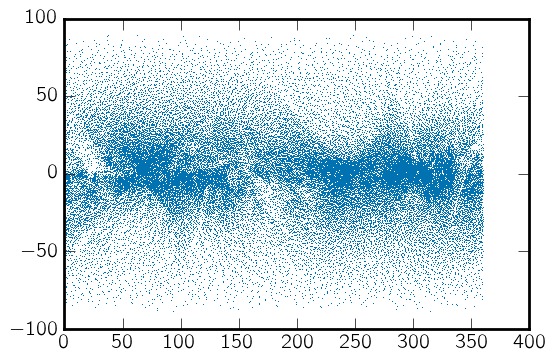

In [29]:
plot(tgas.l[::50], tgas.b[::50], ',')

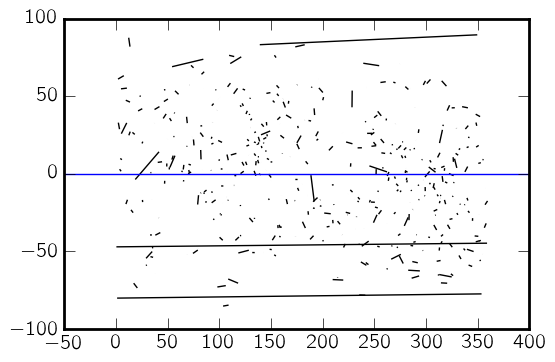

In [30]:
for g in Gc[sizes==2][::10]:
    pos = {node:(tgas.l[node], tgas.b[node]) for node in g.nodes()}
    nx.draw_networkx_edges(g, pos)

axhline(0)

In [23]:
diffb = []
for g in Gc[sizes==2]:
    n1, n2 = g.nodes()
    diffb.append(tgas.b[n1] - tgas.b[n2])

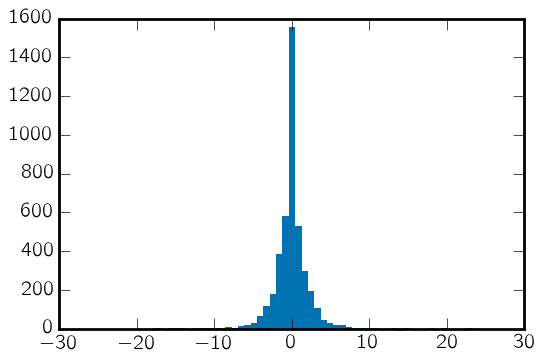

In [27]:
_ = hist(diffb, 64)

In [ ]:
k
